# **인물사진을 만들어보자**

## Step 1. 인물모드 직접 해보기

### 1. 사진 준비하기

In [1]:
# 모듈 불러오기

import os
import urllib   # 웹에서 데이터 다운로드할 때 사용
import cv2      # OpenCV 라이브러리로 이미지를 처리하기 위해 필요
import numpy as np
from pixellib.semantic import semantic_segmentation   # 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

(890, 1202, 3)


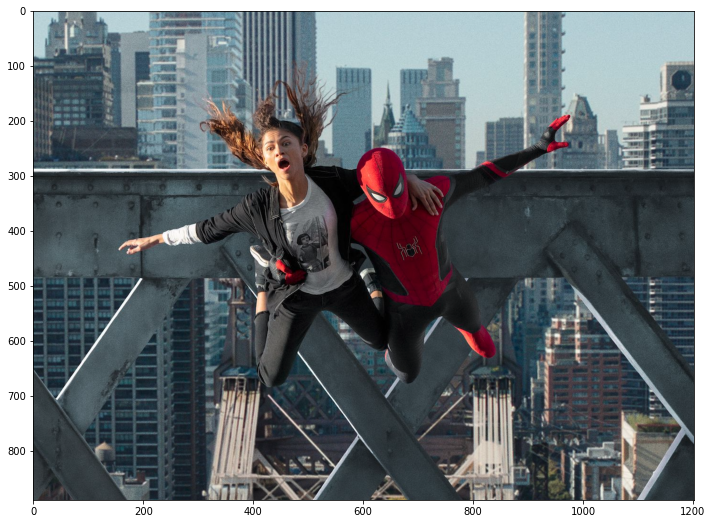

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/nowayhome.png'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.figure(figsize=(13,9))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

---

### 2. Segmentation으로 사람 분리하기

먼저 PixelLib에서 제공해주는 모델 다운로드하기

In [3]:
# 저장할 파일 이름 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 모델 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fde22df2040>)

 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

모델에 이미지 입력

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)

segmentAsPascalvoc 라는 함수에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있다. PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미이다.<br>
모델마다 학습시킨 데이터에 따라 결과값이 달라진다.<br>

In [6]:
# PASCAL VOC 데이터의 라벨 종류

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

<function matplotlib.pyplot.show(close=None, block=None)>

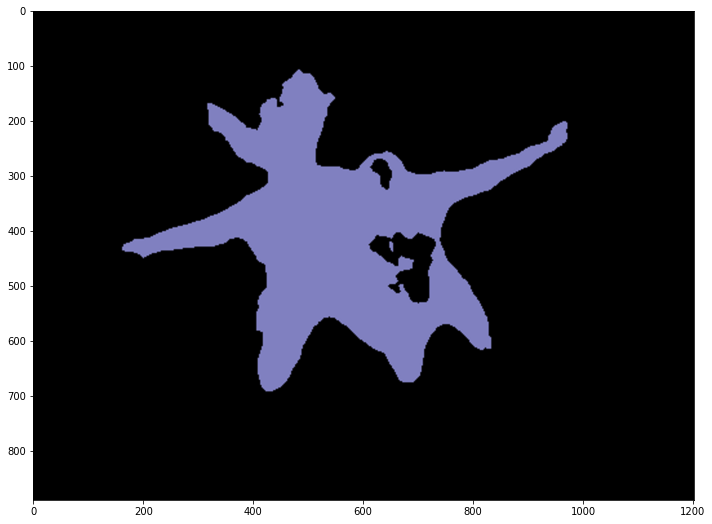

In [7]:
# 모델에서 나온 출력값 살펴보기

plt.figure(figsize=(13,9))
plt.imshow(output)
plt.show

In [8]:
# class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있음
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
# class_id와 라벨 이름을 짝지어주기
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [10]:
# PixelLib 상에서 물체마다 output에 어떤 색상으로 나타나있는지만 알아보기


colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:21]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0],
       [  0,  64, 128]])

In [11]:
# 15번째 물체(person)을 나타내는 색상

colormap[15]

array([192, 128, 128])

In [12]:
# 추출해야하는 색상값의 순서 바꿔주기 (Output 이미지는 BGR 순서로 채널 배치, colormap은 RGB 순서)

seg_color = (128, 128, 192)

(890, 1202)


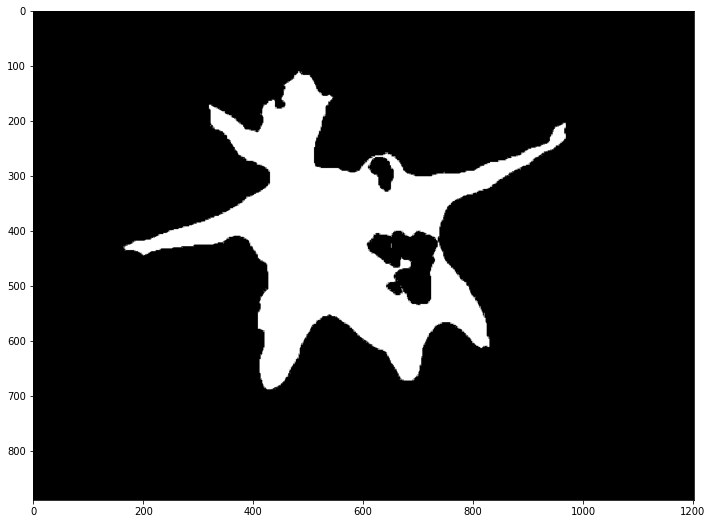

In [13]:
# seg_color로만 이루어진 마스크 만들기

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 된다.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.figure(figsize=(13,9))
plt.imshow(seg_map, cmap='gray')
plt.show()

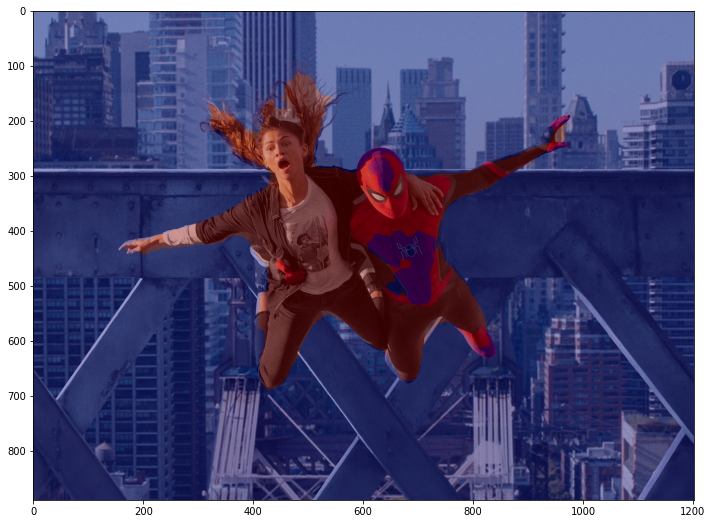

In [14]:
# 원래 이미지와 마스크 겹쳐보기

img_show = img_orig.copy()

# True와 False인 값을 각각 255와 0으로 바꿔주기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔보기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐보기
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.figure(figsize=(13,9))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

---

### 3. 배경 흐리게 하기

blur 함수 이용해서 배경 흐리게 만들기

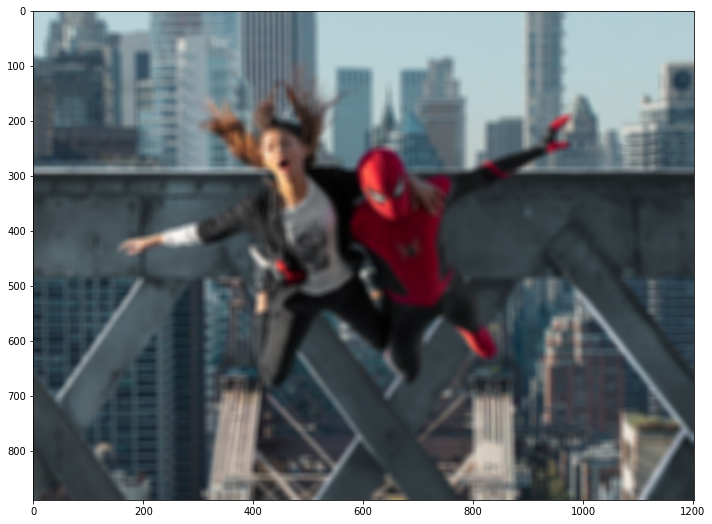

In [15]:
# (13,13)은 blurring kernel size를 뜻함. 다양하게 바꿔보기
img_orig_blur = cv2.blur(img_orig, (14,14))
plt.figure(figsize=(13,9))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출하기

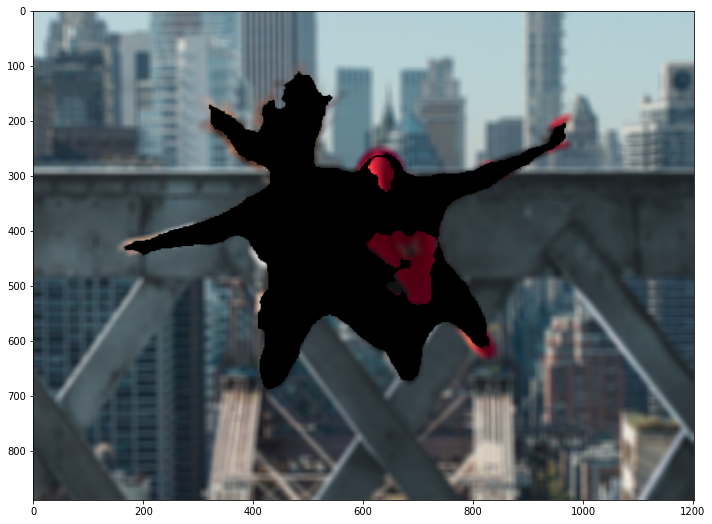

In [16]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # bitwise_not 연산을 통해 이미지 반전시키기 (배경 0, 사람 255 -> 배경 255, 사람 0)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
# bitwise_and 연산을 통해 배경만 있는 영상 추출 (0을 곱하면 다 0이 되기 때문에 사람이 있던 픽셀이 0이 됨)
plt.figure(figsize=(13,9))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

---

### 4. 흐린 배경과 원본 영상 합성

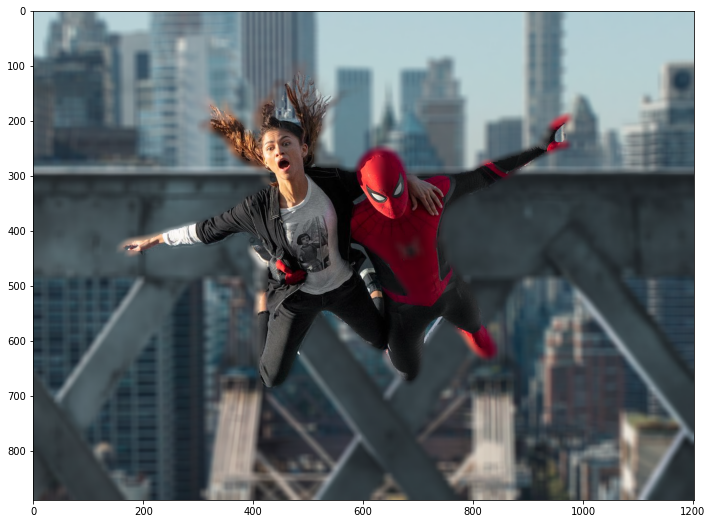

In [17]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) # np.where(조건, 참일 때, 거짓일 때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용
plt.figure(figsize=(13,9))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

---

### 5. 고양이 사진으로 해보기

(494, 491, 3)


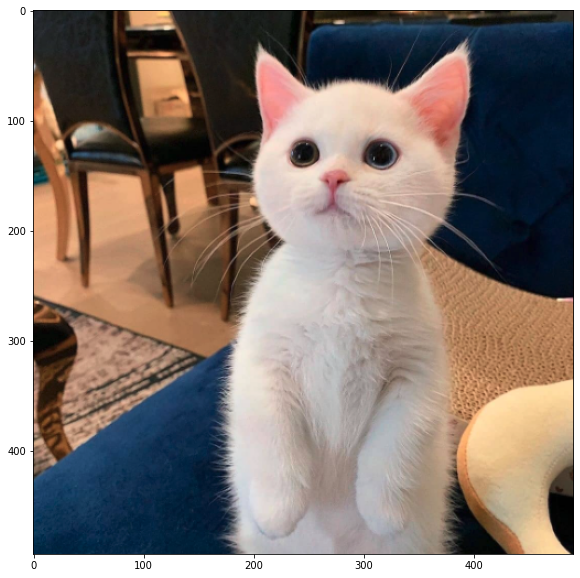

In [18]:
# 사진 준비하기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
# 모델에 이미지 입력

segvalues, output = model.segmentAsPascalvoc(img_path)

<function matplotlib.pyplot.show(close=None, block=None)>

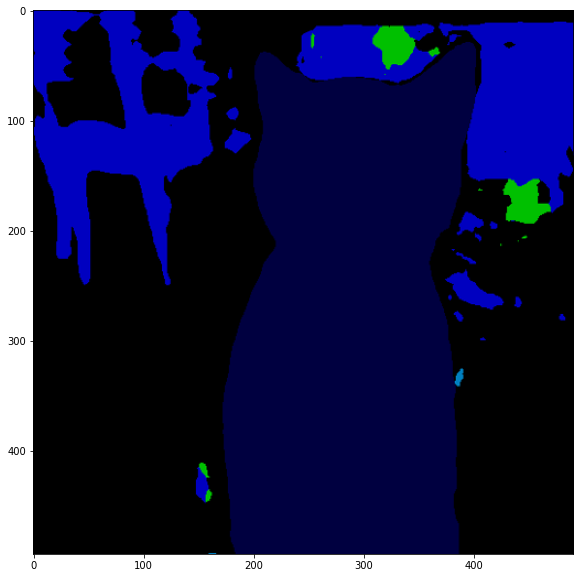

In [20]:
# 모델에서 나온 출력값 살펴보기

plt.figure(figsize=(10,10))
plt.imshow(output)
plt.show

In [21]:
# class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있음
segvalues

{'class_ids': array([ 0,  8,  9, 11, 18]),
 'masks': array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [22]:
# class_id와 라벨 이름을 짝지어주기
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
chair
diningtable
sofa


In [23]:
# 고양이를 나타내는 색상

colormap[8]

array([64,  0,  0])

In [24]:
# 추출해야하는 색상값의 순서 바꿔주기 (Output 이미지는 BGR 순서로 채널 배치, colormap은 RGB 순서)

seg_color = (0, 0, 64)

(494, 491)


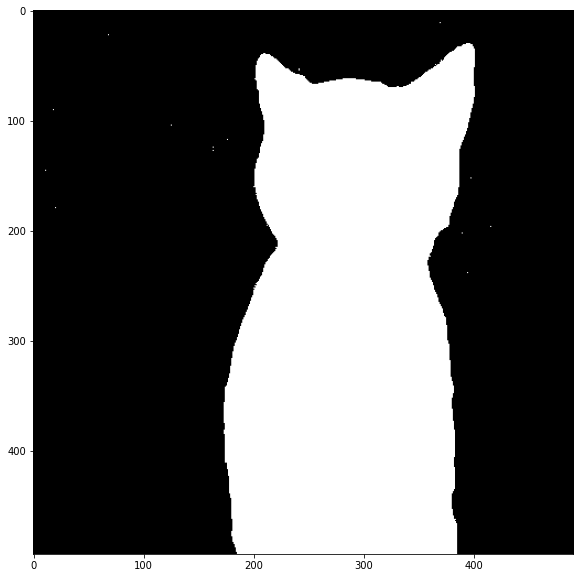

In [25]:
# seg_color로만 이루어진 마스크 만들기

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 된다.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.figure(figsize=(10,10))
plt.imshow(seg_map, cmap='gray')
plt.show()

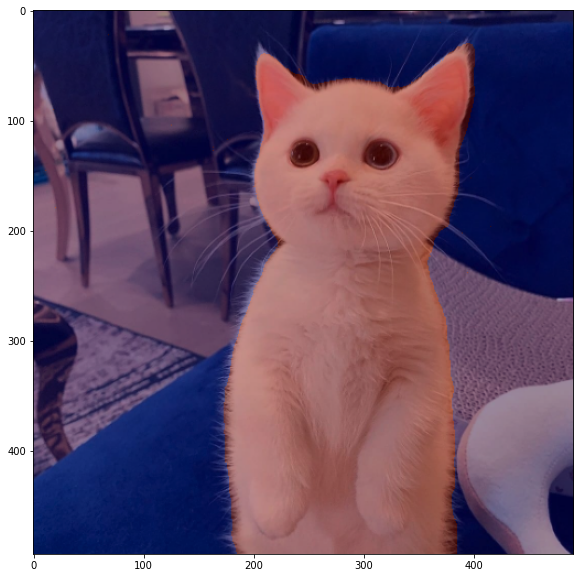

In [26]:
# 원래 이미지와 마스크 겹쳐보기

img_show = img_orig.copy()

# True와 False인 값을 각각 255와 0으로 바꿔주기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔보기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐보기
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

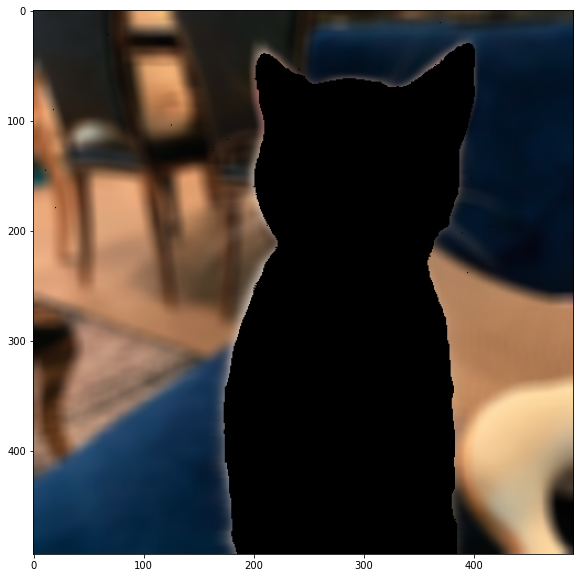

In [27]:
# 배경 흐리게 하고 세그멘테이션 마스크 이용해서 배경 추출하기

img_orig_blur = cv2.blur(img_orig, (14,14))
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # bitwise_not 연산을 통해 이미지 반전시키기 (배경 0, 고양이 255 -> 배경 255, 고양이 0)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
# bitwise_and 연산을 통해 배경만 있는 영상 추출 (0을 곱하면 다 0이 되기 때문에 고양이가 있던 픽셀이 0이 됨)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

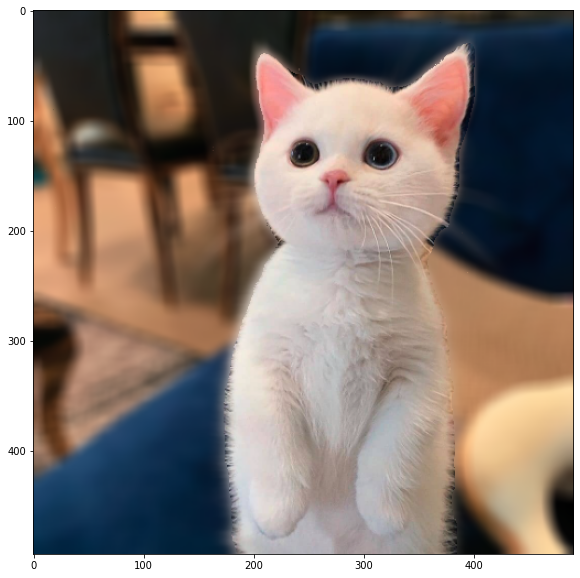

In [28]:
# 흐린 배경과 원본 영상 합성하기

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) # np.where(조건, 참일 때, 거짓일 때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

---

### 6. 크로마키 배경 합성해보기

(390, 691, 3)


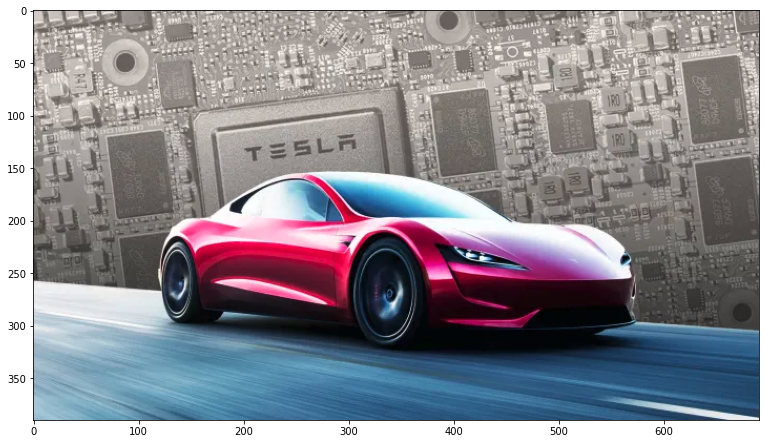

In [29]:
# 사진 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/tesla.png'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.figure(figsize=(13,9))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [30]:
# 모델에 이미지 입력

segvalues, output = model.segmentAsPascalvoc(img_path)

<function matplotlib.pyplot.show(close=None, block=None)>

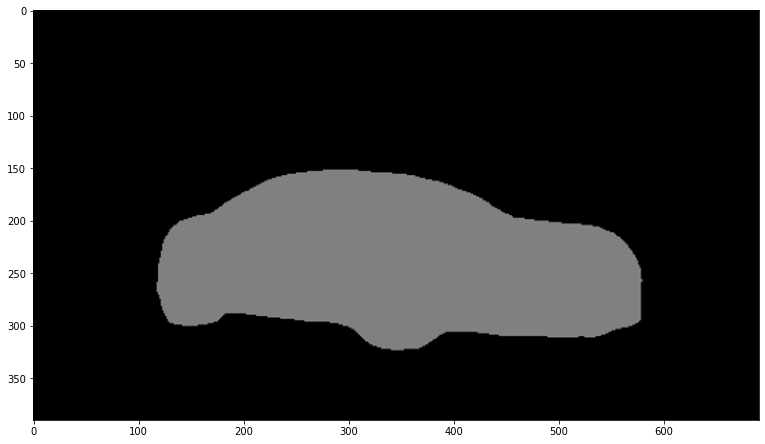

In [31]:
# 모델에서 나온 출력값 살펴보기

plt.figure(figsize=(13,9))
plt.imshow(output)
plt.show

In [32]:
# class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있음
segvalues

{'class_ids': array([0, 7]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [33]:
# class_id와 라벨 이름을 짝지어주기
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
car


In [34]:
# 차를 나타내는 색상

colormap[7]

array([128, 128, 128])

In [35]:
# 차는 BGR, RGB 순서 똑같으므로 색상 변수 지정만 해주기

seg_color = (128, 128, 128)

(390, 691)


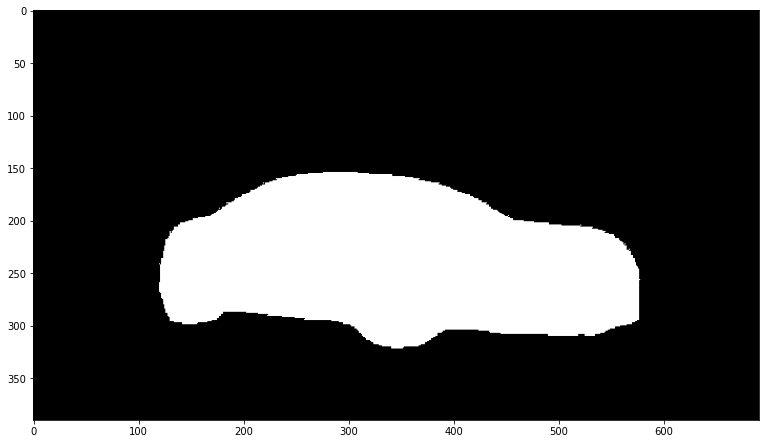

In [36]:
# seg_color로만 이루어진 마스크 만들기

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 된다.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.figure(figsize=(13,9))
plt.imshow(seg_map, cmap='gray')
plt.show()

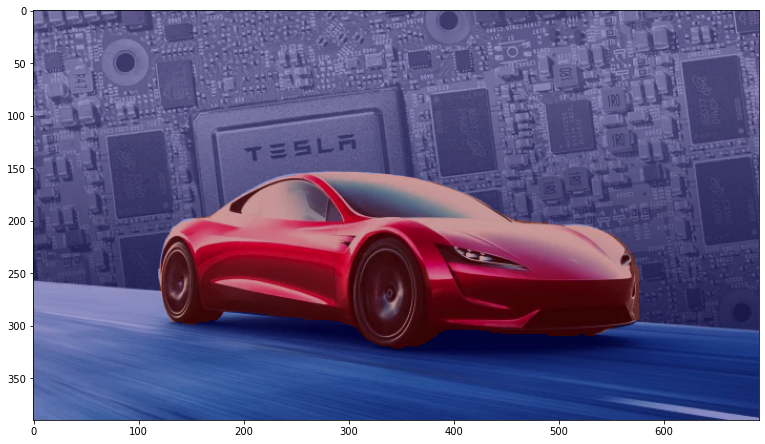

In [37]:
# 원래 이미지와 마스크 겹쳐보기

img_show = img_orig.copy()

# True와 False인 값을 각각 255와 0으로 바꿔주기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔보기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐보기
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.figure(figsize=(13,9))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

(358, 639, 3)
(390, 691, 3)


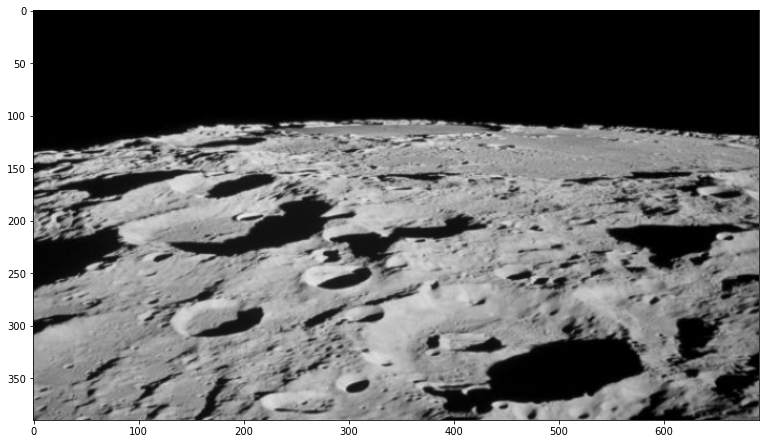

In [38]:
# 합성할 배경 사진 불러와서 같은 크기로 Resize하기
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/moon.png'
bg_orig = cv2.imread(bg_path)
print(bg_orig.shape)

bg_resized = cv2.resize(bg_orig, (691, 390))
print(bg_resized.shape)

plt.figure(figsize=(13,9))
plt.imshow(cv2.cvtColor(bg_resized, cv2.COLOR_BGR2RGB))
plt.show()

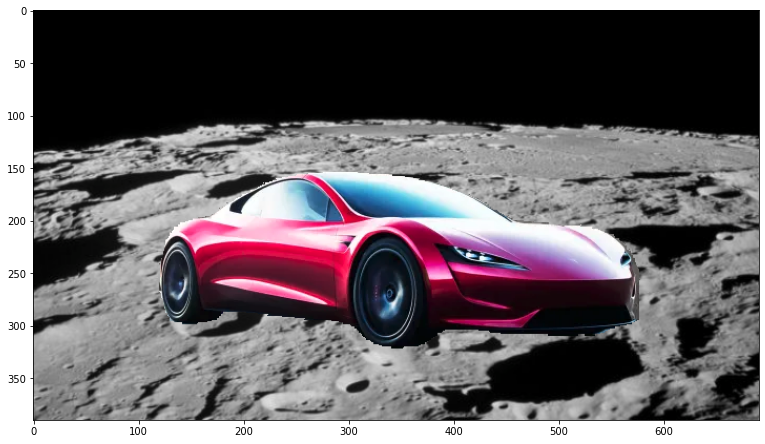

In [39]:
# 원본에 배경 합성하기

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_concat = np.where(img_mask_color==255, img_orig, bg_resized) # np.where(조건, 참일 때, 거짓일 때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 배경 값을 사용
plt.figure(figsize=(13,9))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

---

## Step 2. 사진에서 문제점 찾기

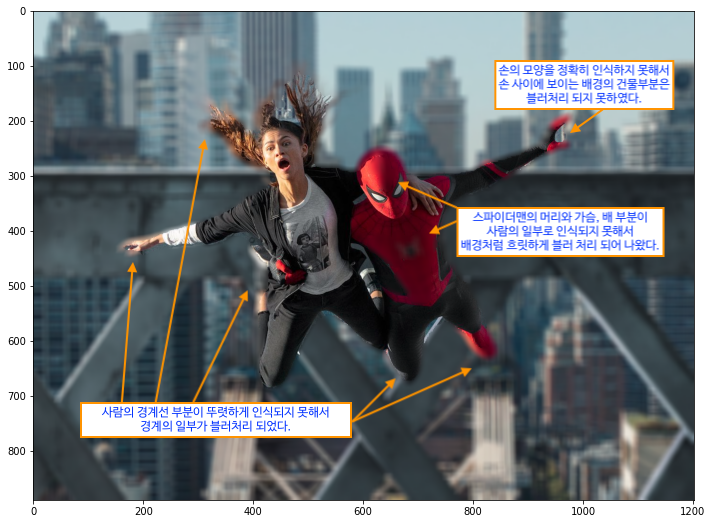

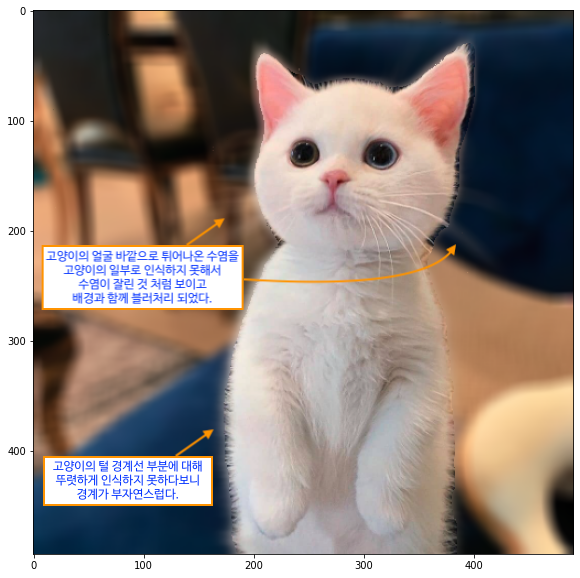

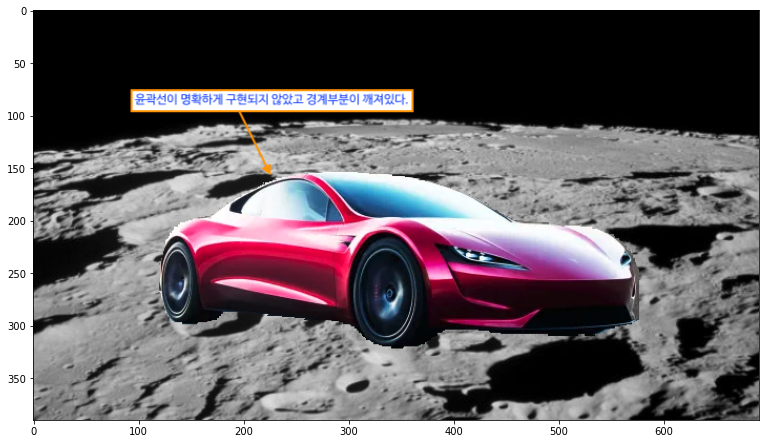

---

## Step 3. 해결방법 제안해 보기

#### 위의 작업들을 통해 발견한 한계

위 사진들에서 볼 수 있는 가장 크고 주요한 문제점은, 각 물체의 윤곽선, 경계 부분의 구분이 모호하다는 것이다. 애매한 경계 처리 때문에 물체로 인식되어야 할 부분이 흐릿하게 배경처럼 처리되었다든가, 배경으로 인식되어야 할 부분이 물체로 인식되어서 뚜렷하게 처리되는 결과가 생긴다.

이러한 문제점의 가장 큰 원인은 우리가 지금 다루고 있는 이미지들이 모두 2D 이미지이기 때문이다. 실제로 초점을 맞추고 또 초점을 흐릿하게 하는 작업이 아니라 단순히 이미지의 구성요소들을 분리해서 흐리게 만드는 것이기 때문에, 각 구성요소의 영역을 구분짓는 수준에 그치고 있는 것이다. 

#### 생각해 볼 수 있는 요소들

단순히 2D 이미지 상에서 구성요소들을 분리할 때 경계를 좀더 명확히 구분하는 방법에 대해서 생각해보자면, 위의 작업들을 통해 각 물체의 영역은 대충 구분지을 수 있으니 그 경계선에 집중해서 좀더 세세히 작업을 처리해볼 필요가 있다. 각 픽셀 값에는 색상값이 들어가 있기 때문에 경계선 픽셀들의 색상값들을 쭉 비교해봤을 때 명확하게 변화되는 지점을 파악하고 그 부분의 블러처리를 없애거나, 그 경계 바깥쪽에 블러처리가 안되어있는 부분은 블러처리를 해주면 될 것이다. 그러나 이 방법은 하나 하나 수작업을 해야할 수도 있고, 또 색상이 명확하게 구분이 되지 않는 배경과 물체가 있다면 사용하기가 어렵다. 결국 모델의 학습량을 늘리거나 해서 확연하게 물체의 경계선 하나하나를 구분지을 수 있을 때까지 성능을 높이는 방법 밖에 떠오르지 않는다.

실제로 아웃포커싱은 3차원 공간을 통해 거리를 인식할 수 있으므로 피사계 심도를 이용하여 물체 간의 거리의 차이를 고려해서 초점이 맞는 대상을 구분짓게 된다. 우리가 이를 이용하여 2D 이미지 상에서도 물체 간의 거리를 인식하고 측정하여 구분지을 수 있으면 경계를 좀 더 명확하게 구분지을 수 있을 것이다.
<br>3D 이미지 센서들의 동작 원리를 살펴보면, 레이저를 이용해 물체로부터 반사되어 되돌아온 신호의 위상 차이나 시간 차이를 측정해서 물체까지의 거리를 탐지하는 방식이다. 근데 2D 이미지 상에서는 그런 작업이 불가능하다. 그 대신 우리는 아이폰의 인물사진 모드 작동방식에서 힌트를 얻을 수 있을 것 같다. 아이폰의 인물사진 모드는 렌즈 두 개를 활용하여 거리에 따라 물체와 배경을 구분하여 초점을 다르게 맞추는 작업을 한다. 똑같은 물체를 각각 다른 각도에서 찍은 사진들이 두 장 이상 있다면, 그 두 사진을 비교하여 물체와 그 외의 것들의 거리를 대충 측정할 수 있을 것이다. 그를 통해 거리값에 대한 정보도 픽셀에 넣어주면 훨씬 더 명확한 구분이 될 수 있을 것이다.

---

## 회고

- 처음에 스파이더맨도 사람으로 인식할까 궁금해하면서 사진을 사용했는데, 사람으로 인식이 된 건 좋았지만 중간에 얼굴과 배 부분이 구멍 뚫린 것처럼 인식이 되어서 뭔가 찝찝하고 기분이 이상했다. 거기서부터 이 모델에 대한 신뢰감이 떨어졌다.

- 모델이 고양이와 차까지 인식을 다할 수 있다는 부분은 신기했지만, 경계선 부분이 너무 모호하게 작업이 되어서 아쉬웠다. 다음에 좀 더 다양한 구성요소가 들어있는 사진으로 구분 작업을 해봐야겠다.

- Semantic Segmentation을 활용하여 사진의 구성요소를 파악하여 구분하는 작업이 재밌긴 했지만, 만들어진 모델로 쓱 해서 결과물도 쓱 나오니 뭔가 입맛만 다시는 느낌이었다. 정확하게 저 모델이 어떻게 작동하고 진행되는지가 궁금했고, 그 과정을 모르니깐 나중에 해결책을 고민할 때도 아는 것이 많이 없어서 억지로 쥐어 짜내는 느낌이었다.

- 해결책을 생각해내는 것이 정말 중요한 작업이고 필요한 부분이긴 하지만 뭔가 내가 아는 것이 너무 없고 자료들에서 유추해내는 것도 한계가 있는 것 같아서 이번 프로젝트의 결론은 좀 망한 것 같다. 아직 그렇게까지 생각하기에 너무 어렵고 너무 뜬구름만 잡는 느낌이다. 실제로 영상 합성하는 기술들을 좀더 공부해보고 접목해서 딥러닝 모델에 활용할 수 있는 부분들을 더 알아간다면 그 때는 좀더 재밌을 것 같고 의미가 있을 것 같다. 이번엔 맛보기만 해본걸로..